In [1]:
import os
import tejapi

os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = 'YOUR KEY'

import TejToolAPI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import alphalens
from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline import Pipeline
from logbook import Logger, StderrHandler, INFO
import sys
import time
print(sys.executable)
print(sys.version)
print(sys.prefix)

log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

from zipline.api import (attach_pipeline,
                         pipeline_output,
                         record,
                         schedule_function,
                         set_slippage,
                         set_commission,
                         order_target,
                         order_target_percent,
                         set_benchmark,
                         symbol,sid,
                         get_datetime,
                         get_open_orders,
                         cancel_order,
                         order,
                         set_max_leverage,
                         cancel_order
                         )
import zipline

from zipline.finance import commission, slippage
from zipline.finance.commission import PerDollar , NoCommission, PerTrade, PerShare, PerContract
from zipline.finance.slippage import VolumeShareSlippage, NoSlippage
from zipline.utils.events import date_rules, time_rules

from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar

from zipline.api import future_symbol, \
    set_commission, set_slippage, schedule_function, date_rules, \
    time_rules, continuous_future, order_target
from zipline.assets import Equity, Future


C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing\python.exe
3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)]
C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing


### **股票期貨契約調整方式與模擬回測處理原則**  
根據台灣期貨交易所公告的股票期貨契約調整辦法，主要依據標的證券公司發生的公司事件及股東所受配發的利益進行調整，具體方式如下：  

- **除息（現金股利）**：於除息日調整買賣方權益數，調整金額以每 2,000 股所配發之現金為基準。  
- **除權（股票股利）**：於除權日調整約定標的物，每口合約表彰股數增加，以納入股票股利。  
- **現金增資（現金增資認購權）**：於現金增資除權日調整約定標的物，納入相當於現金增資的價值。 
- **現金減資（減資換股）**：於減資換股生效日調整約定標的物，每口合約表彰股數將依換股比例進行調整，並根據開盤參考價與新股數調整買賣雙方權益，以確保權益數維持不變。

**TQuant Lab 進行模擬期貨回測時，也會根據上述公司事件進行相應調整**。**<span style="color:red; font-weight:bold;">然而，調整方式並不涉及新舊合約的轉換，而是於契約調整生效日，以現金返還或繳回的方式處理，直接反映於投資組合帳戶的現金部位</span>**。以下將以範例說明，在期貨契約調整時，TQuant Lab回測時現金返還得假設處理方法。


## **📌 1. 除息日當日持有期貨契約現金返還範例 - 以台積電期貨契約為例**  

- 公司事件：台積電於2024/12/12因配發2024Q2現金股利除息3.999元。

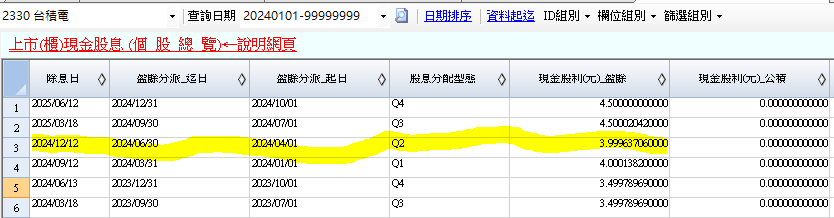

In [2]:
os.environ['ticker'] = '2330 IR0001'
os.environ['future'] = 'CDF'
os.environ['mdate'] = '20230101 20250318'
!zipline ingest -b tquant_future

def initialize(context):    
    # 設定 benchmark
    context.set_benchmark(symbol('IR0001'))
    context.root_symbol = 'CDF'
    context.tick = '2330'
    # 交易成本
    set_commission(equities=PerDollar(cost=0.003),futures=PerContract(cost={context.root_symbol:200},exchange_fee=0))
    set_slippage(equities=NoSlippage(),futures=NoSlippage())
    context.buy = False    

    context.continue_fut = continuous_future(context.root_symbol, offset=0, roll='calendar', adjustment='add')
  
def handle_data(context, data):
    today = data.current_session.date()        
    contract = data.current(context.continue_fut, 'contract')
    
    if context.buy==False:
        order(contract,1)
        context.buy=True
        context.ordercontract = contract
    
    record(futures_contract = context.ordercontract ,
           futures_price =data.current(context.ordercontract  ,'close'),
           security_price =data.current(symbol(context.tick),'close')
          )
    
capital_base = 1e6
calendar_name = 'TEJ'
start_dt = pd.Timestamp('2024-12-08', tz='utc')
end_dt = pd.Timestamp('2024-12-16', tz='utc')
# Running a Backtest
results = run_algorithm(start=start_dt,
                        end=end_dt,
                        initialize=initialize,
                        handle_data = handle_data,
                        capital_base=capital_base,
                        data_frequency='daily',
                        bundle='tquant_future',
                        trading_calendar=get_calendar(calendar_name),
                        )  	
results[['starting_cash','ending_cash','long_exposure','longs_count','portfolio_value','futures_contract','futures_price','security_price']]

Merging daily equity files:


C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
[2025-05-28 07:20:59.498745] INFO: zipline.data.bundles.core: Ingesting tquant_future.
[2025-05-28 07:21:01.042020] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=6, ex_date=2023-03-16, amount=2.750
[2025-05-28 07:21:01.089400] INFO: zipline.data.bundles.core: Ingest tquant_future successfully.
[2025-05-28 07:21:02.090509]: INFO: earn_dividends: Future(25 [CDF202412]), cash_dividend amount: 3.99963706, pay_date: 2024-12-12, div_owed: 7999.27412
[2025-05-28 07:21:02.106146]: INFO: handle_simulation_end: Simulated 6 trading days
first open: 2024-12-09 01:01:00+00:00
last close: 2024-12-16 05:30:00+00:00


,starting_cash,ending_cash,long_exposure,longs_count,portfolio_value,futures_contract,futures_price,security_price
2024-12-09 13:30:00+08:00,1000000.00000,1.000000e+06,0.0,0,1.000000e+06,Future(25 [CDF202412]),1075.0,1075.0
2024-12-10 13:30:00+08:00,1000000.00000,9.998000e+05,2130000.0,1,9.998000e+05,Future(25 [CDF202412]),1065.0,1065.0
2024-12-11 13:30:00+08:00,999800.00000,9.698000e+05,2100000.0,1,9.698000e+05,Future(25 [CDF202412]),1050.0,1045.0
2024-12-12 13:30:00+08:00,977799.27412,9.977993e+05,2120000.0,1,9.977993e+05,Future(25 [CDF202412]),1060.0,1060.0
2024-12-13 13:30:00+08:00,997799.27412,9.977993e+05,2120000.0,1,9.977993e+05,Future(25 [CDF202412]),1060.0,1065.0
2024-12-16 13:30:00+08:00,997799.27412,1.037799e+06,2160000.0,1,1.037799e+06,Future(25 [CDF202412]),1080.0,1085.0



#### **📅 交易流程**  
✅ **12/10**：買進 **台積電期貨 1 口** （等價 **2 張** 台積電股票）  
✅ **12/12（除息日）**：當日開盤 **除息點數 3.999**，台積電股票期貨收盤較前一個交易日 **上漲 10 元**（1050 ➝ 1060）  

---

#### **💰 12/12投資組合變化**  
📈 **台積電股價上漲**：  
- **獲利計算**：`10 × 2000 = 20,000` 元 (**long exposure 較昨日增加**)  

💵 **除息現金返還**：  
- **契約返還現金**：`3.9996 × 2000 = 7,999` 元 (**starting_cash 較昨日增加**)  

📊 **整體投資組合變動**：  
- **總增值**：`27,999` 元  
- **12/11到12/12資產變化(portfolio_value)**：`969,800.0` ➝ **`997,799.3`**  

---


## **📌 2. 除權日當日持有期貨契約現金返還範例 - 以中天期貨契約為例**  
- 公司事件：中天於2024/08/29因配發2023年股票股利除權0.5元。

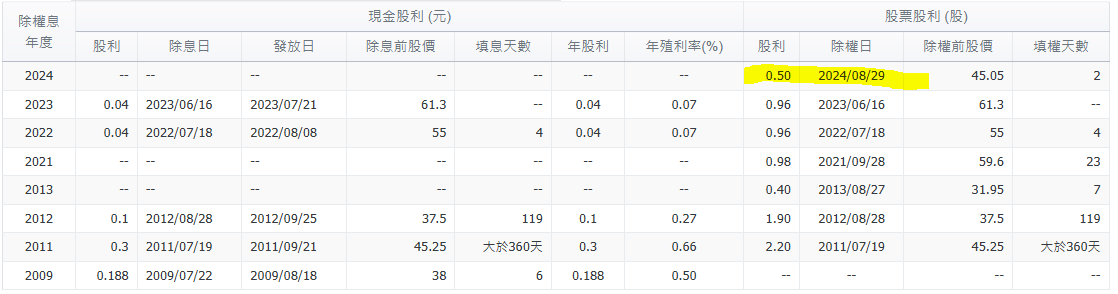

In [3]:
os.environ['ticker'] = '4128 IR0001'
os.environ['future'] = 'RDF'
os.environ['mdate'] = '20230101 20250318'
!zipline ingest -b tquant_future

def initialize(context):
# 設定 benchmark 
    context.set_benchmark(symbol('IR0001')) 
    context.root_symbol = 'RDF' 
    context.tick = '4128' 
    # 交易成本 
    set_commission(equities=PerDollar(cost=0.003),futures=PerContract(cost={context.root_symbol:200},exchange_fee=0)) 
    set_slippage(equities=NoSlippage(),futures=NoSlippage()) 
    context.buy = False

    context.continue_fut = continuous_future(context.root_symbol, offset=0, roll='calendar', adjustment='add')
    
def handle_data(context, data): 
    today = data.current_session.date()
    contract = data.current(context.continue_fut, 'contract')

    if context.buy==False:
        order(contract,1)
        context.buy=True
        context.ordercontract = contract
    
    record(futures_contract = context.ordercontract ,
           futures_price =data.current(context.ordercontract  ,'close'),
           security_price =data.current(symbol(context.tick),'close')
          )

capital_base = 1e6 
calendar_name = 'TEJ' 
start_dt = pd.Timestamp('2024-08-25', tz='utc') 
end_dt = pd.Timestamp('2024-08-31', tz='utc')

# Running a Backtest
results = run_algorithm(start=start_dt, 
                        end=end_dt, 
                        initialize=initialize, 
                        handle_data = handle_data, 
                        capital_base=capital_base, 
                        data_frequency='daily', 
                        bundle='tquant_future', 
                        trading_calendar=get_calendar(calendar_name), ) 

results[['starting_cash','ending_cash','long_exposure','longs_count','portfolio_value','futures_contract','futures_price','security_price']]

C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
[2025-05-28 07:21:08.620346] INFO: zipline.data.bundles.core: Ingesting tquant_future.
[2025-05-28 07:21:09.986402] INFO: zipline.data.bundles.core: Ingest tquant_future successfully.
[2025-05-28 07:21:10.720435]: INFO: earn_dividends: Future(21 [RDF202409]), cash_dividend amount: 2.152380901133787, pay_date: 2024-08-29, div_owed: 4304.761802267574
[2025-05-28 07:21:10.738545]: INFO: handle_simulation_end: Simulated 5 trading days
first open: 2024-08-26 01:01:00+00:00
last close: 2024-08-30 05:30:00+00:00


Merging daily equity files:


,starting_cash,ending_cash,long_exposure,longs_count,portfolio_value,futures_contract,futures_price,security_price
2024-08-26 13:30:00+08:00,1.000000e+06,1.000000e+06,0.0,0,1.000000e+06,Future(21 [RDF202409]),44.1,44.00
2024-08-27 13:30:00+08:00,1.000000e+06,9.998000e+05,89200.0,1,9.998000e+05,Future(21 [RDF202409]),44.6,44.65
2024-08-28 13:30:00+08:00,9.998000e+05,1.001000e+06,90400.0,1,1.001000e+06,Future(21 [RDF202409]),45.2,45.05
2024-08-29 13:30:00+08:00,1.005305e+06,9.997048e+05,84800.0,1,9.997048e+05,Future(21 [RDF202409]),42.4,42.20
2024-08-30 13:30:00+08:00,9.997048e+05,1.001905e+06,87000.0,1,1.001905e+06,Future(21 [RDF202409]),43.5,43.50



#### **📅 交易流程**  
✅ **08/27**：買進 **中天期貨 1 口** （等價 **2 張** 中天股票）  
✅ **08/29（除權日）**：當日開盤 **除權 0.5元**，中天股票期貨收盤較前一交易日 **下跌 2.8 元**（45.2 ➝ 42.4）  

---

#### **💰 08/29投資組合變化**  
📈 **中天股價下跌**：  
- **獲利計算**：`-2.8 × 2000 = -5,600` 元 (**long exposure 較昨日減少**)  

💵 **除權現金返還**：  
- **計算8/29除權開盤參考價**:  `45.2 / 1.05 = 43.0476` 元
- **契約返還現金**：`0.5 /10 × 2000 × 43.0476 = 4,304.76` 元 (**starting_cash 較昨日增加，開盤即以開盤參考價和除權股數返還現金**)  

📊 **整體投資組合變動**：  
- **總增值**：`-1,295.2` 元  
- **8/28到8/29資產變化(portfolio_value)**：`1,001,000` ➝ **`999,704.8`**  

---


## **📌 3. 除權息日當日持有期貨契約現金返還範例 - 以台企銀期貨契約為例**  
- 公司事件：台企銀於2024/08/08因配發2023年現金、股票股利，除息0.2，除權1.15元。

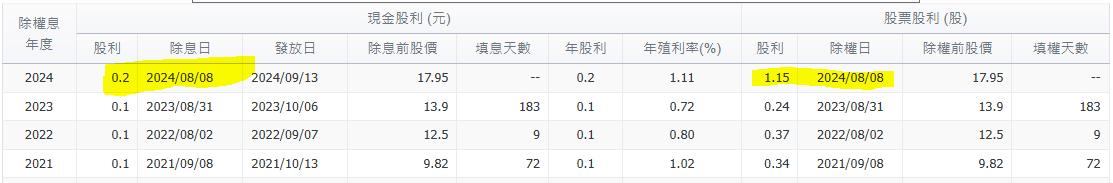

In [4]:
os.environ['ticker'] = '2834 IR0001'
os.environ['future'] = 'IAF'
os.environ['mdate'] = '20230101 20250318'
!zipline ingest -b tquant_future

def initialize(context):
# 設定 benchmark 
    context.set_benchmark(symbol('IR0001')) 
    context.root_symbol = 'IAF' 
    context.tick = '2834' 
    # 交易成本 
    set_commission(equities=PerDollar(cost=0.003),futures=PerContract(cost={context.root_symbol:200},exchange_fee=0)) 
    set_slippage(equities=NoSlippage(),futures=NoSlippage()) 
    context.buy = False

    context.continue_fut = continuous_future(context.root_symbol, offset=0, roll='calendar', adjustment='add')
    
def handle_data(context, data): 
    today = data.current_session.date()
    contract = data.current(context.continue_fut, 'contract')

    if context.buy==False:
        order(contract,1)
        context.buy=True
        context.ordercontract = contract
    
    record(futures_contract = context.ordercontract ,
           futures_price =data.current(context.ordercontract  ,'close'),
           security_price =data.current(symbol(context.tick),'close')
          )

capital_base = 1e6 
calendar_name = 'TEJ' 
start_dt = pd.Timestamp('2024-08-06', tz='utc') 
end_dt = pd.Timestamp('2024-08-09', tz='utc')

# Running a Backtest
results = run_algorithm(start=start_dt, 
                        end=end_dt, 
                        initialize=initialize, 
                        handle_data = handle_data, 
                        capital_base=capital_base, 
                        data_frequency='daily', 
                        bundle='tquant_future', 
                        trading_calendar=get_calendar(calendar_name), ) 

results[['starting_cash','ending_cash','long_exposure','longs_count','portfolio_value','futures_contract','futures_price','security_price']]

C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
[2025-05-28 07:21:17.258774] INFO: zipline.data.bundles.core: Ingesting tquant_future.
[2025-05-28 07:21:18.941646] INFO: zipline.data.bundles.core: Ingest tquant_future successfully.
[2025-05-28 07:21:19.672233]: INFO: earn_dividends: Future(21 [IAF202408]), cash_dividend amount: 2.051345291479821, pay_date: 2024-08-08, div_owed: 4102.690582959643
[2025-05-28 07:21:19.690458]: INFO: handle_simulation_end: Simulated 4 trading days
first open: 2024-08-06 01:01:00+00:00
last close: 2024-08-09 05:30:00+00:00


Merging daily equity files:


,starting_cash,ending_cash,long_exposure,longs_count,portfolio_value,futures_contract,futures_price,security_price
2024-08-06 13:30:00+08:00,1.000000e+06,1000000.000000,0.0,0,1000000.000000,Future(21 [IAF202408]),17.65,17.60
2024-08-07 13:30:00+08:00,1.000000e+06,999800.000000,36300.0,1,999800.000000,Future(21 [IAF202408]),18.15,17.95
2024-08-08 13:30:00+08:00,1.003903e+06,998902.690583,31300.0,1,998902.690583,Future(21 [IAF202408]),15.65,15.60
2024-08-09 13:30:00+08:00,9.989027e+05,999202.690583,31600.0,1,999202.690583,Future(21 [IAF202408]),15.80,15.80


#### **📅 交易流程**  
✅ **08/07**：買進 **台企銀期貨 1 口** （等價 **2 張** 台企銀股票）  
✅ **08/08（除權息日）**：當日開盤 **除權 1.15元、除息0.2元**，台企銀股票期貨收盤 **下跌 2.5 元**（18.15 ➝ 15.65）  

---

#### **💰 08/08投資組合變化**  
📈 **台企銀股價下跌**：  
- **獲利計算**：`-2.5 × 2000 = -5,000` 元 (**long exposure 較昨日減少**)  

💵 **除權現金返還**：  
- **計算8/8除權開盤參考價**:  `(18.15-0.2) / 1.115 = 16.0986` 元
- **契約返還現金**：`(18.15-0.2)/1.115*(1.15/10)*2000+0.2*2000 = 4,102.69` 元 (**starting_cash 較昨日增加，開盤即以開盤參考價和除權股數返還現金**)  

📊 **整體投資組合變動**：  
- **總增值**：`-897.31` 元  
- **8/7到8/8資產變化(portfolio_value)**：`999,800` ➝ **`998,902.69`**  

---


## **📌 4. 現金增資當日持有期貨契約現金返還範例 - 以新光金期貨契約為例**  
- 公司事件：新光金於2024/07/11因辦理現金增資除權，每千股可認購79.34股，每股現增認購價8.3元。

In [5]:
os.environ['ticker'] = '2888 IR0001'
os.environ['future'] = 'DDF'
os.environ['mdate'] = '20230101 20250318'
!zipline ingest -b tquant_future

def initialize(context):
# 設定 benchmark 
    context.set_benchmark(symbol('IR0001')) 
    context.root_symbol = 'DDF' 
    context.tick = '2888' 
    # 交易成本 
    set_commission(equities=PerDollar(cost=0.003),futures=PerContract(cost={context.root_symbol:200},exchange_fee=0)) 
    set_slippage(equities=NoSlippage(),futures=NoSlippage()) 
    context.buy = False

    context.continue_fut = continuous_future(context.root_symbol, offset=0, roll='calendar', adjustment='add')
    
def handle_data(context, data): 
    today = data.current_session.date()
    contract = data.current(context.continue_fut, 'contract')

    if context.buy==False:
        order(contract,1)
        context.buy=True
        context.ordercontract = contract
    
    record(futures_contract = context.ordercontract ,
           # futures_price =data.current(context.ordercontract  ,'close'),
           futures_price =data.current(contract  ,'close'),           
           security_price =data.current(symbol(context.tick),'close')
          )

capital_base = 1e6 
calendar_name = 'TEJ' 
start_dt = pd.Timestamp('2024-07-09', tz='utc') 
end_dt = pd.Timestamp('2024-07-18', tz='utc')

# Running a Backtest
results = run_algorithm(start=start_dt, 
                        end=end_dt, 
                        initialize=initialize, 
                        handle_data = handle_data, 
                        capital_base=capital_base, 
                        data_frequency='daily', 
                        bundle='tquant_future', 
                        trading_calendar=get_calendar(calendar_name), ) 

results[['starting_cash','ending_cash','long_exposure','longs_count','portfolio_value','futures_contract','futures_price','security_price']]

C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
[2025-05-28 07:21:26.280346] INFO: zipline.data.bundles.core: Ingesting tquant_future.
[2025-05-28 07:21:28.672081] INFO: zipline.data.bundles.core: Ingest tquant_future successfully.
[2025-05-28 07:21:29.418722]: INFO: earn_dividends: Future(20 [DDF202407]), cash_dividend amount: 0.249, pay_date: 2024-07-17, div_owed: 498.0
[2025-05-28 07:21:29.438328]: INFO: handle_simulation_end: Simulated 8 trading days
first open: 2024-07-09 01:01:00+00:00
last close: 2024-07-18 05:30:00+00:00


Merging daily equity files:


,starting_cash,ending_cash,long_exposure,longs_count,portfolio_value,futures_contract,futures_price,security_price
2024-07-09 13:30:00+08:00,1000000.0,1000000.0,0.0,0,1000000.0,Future(20 [DDF202407]),11.15,11.00
2024-07-10 13:30:00+08:00,1000000.0,999800.0,23600.0,1,999800.0,Future(20 [DDF202407]),11.80,11.85
2024-07-11 13:30:00+08:00,999800.0,999700.0,23500.0,1,999700.0,Future(20 [DDF202407]),11.75,11.80
2024-07-12 13:30:00+08:00,999700.0,1000200.0,24000.0,1,1000200.0,Future(20 [DDF202407]),12.00,11.95
2024-07-15 13:30:00+08:00,1000200.0,999900.0,23700.0,1,999900.0,Future(20 [DDF202407]),11.85,11.75
2024-07-16 13:30:00+08:00,999900.0,999100.0,22900.0,1,999100.0,Future(20 [DDF202407]),11.45,11.45
2024-07-17 13:30:00+08:00,999598.0,999698.0,23000.0,1,999698.0,Future(20 [DDF202407]),11.50,11.45
2024-07-18 13:30:00+08:00,999698.0,999698.0,0.0,0,999698.0,Future(20 [DDF202407]),11.35,11.25


#### **📅 交易流程**  
✅ **07/10**：買進 **7月份新光金期貨 1 口** （等價 **2 張** 新光金股票）  
✅ **07/11**：新光金股票增資除權，每千股可認購79.34股，每股現增認購價8.3元，繳款截止日7/31日   
✅ **07/17**：新光金7月份期貨到期契約結算。新光金股票現貨收盤價11.45元，新光金期貨結算價11.5元。新光金股票期貨收盤價 上漲 0.05 元（14.45 ➝ 11.50）

---

#### **💰 07/17投資組合變化**  
📈 **新光金股價上漲**：  
- **獲利計算**：`0.05 × 2,000 = 100` 元 (**long exposure 較昨日增加**)  

💵 **到期契約價值因現金增資調整而增加**：  
- **計算7/17現貨收盤價與現金增資價差**:  `11.45 - 8.3 = 3.15` 元
- **到期契約增加**：`(11.45 - 8.3) * 79.3 *2 = 498` 元 

📊 **整體投資組合變動**：  
- **總增值**：`598` 元  
- **7/16到7/17資產變化(portfolio_value)**：`998,700` ➝ **`999,298`**  

---


## **📌 5. 現金減資當日持有期貨契約現金返還範例 - 以群創金期貨契約為例**  
- 公司事件：群創於2024/08/26因辦理現金減資恢復交易，現金減資每股退還股款1.2元，減資換股率為88%。

#### **📅 交易流程**  
✅ **08/13**：買進 **8月份群創期貨 1 口** （等價 **2 張** 群創股票）  
✅ **08/14**：**8月份群創期貨 1 口結算**  
✅ **08/15**：群創股票開始減資暫停交易，直到8/26日才恢復交易。因8月群創期貨已結算，故契約不做調整，所以對投資組合損益並沒有影響


In [6]:
os.environ['ticker'] = '3481 IR0001'
os.environ['future'] = 'DQF'
os.environ['mdate'] = '20230101 20250318'
!zipline ingest -b tquant_future

def initialize(context):
# 設定 benchmark 
    context.set_benchmark(symbol('IR0001')) 
    context.root_symbol = 'DQF' 
    context.tick = '3481' 
    # 交易成本 
    set_commission(equities=PerDollar(cost=0.003),futures=PerContract(cost={context.root_symbol:200},exchange_fee=0)) 
    set_slippage(equities=NoSlippage(),futures=NoSlippage()) 
    context.buy = False

    context.continue_fut = continuous_future(context.root_symbol, offset=1, roll='calendar', adjustment='add')
    
def handle_data(context, data): 
    today = data.current_session.date()
    contract = data.current(context.continue_fut, 'contract')

    if context.buy==False:
        order(contract,1)
        #order(symbol('2330'),100)
        context.buy=True
        context.ordercontract = contract
    
    record(futures_contract = context.ordercontract ,
           futures_price =data.current(context.ordercontract  ,'close'),
           security_price =data.current(symbol(context.tick),'close')
          )

capital_base = 1e6 
calendar_name = 'TEJ' 
start_dt = pd.Timestamp('2024-08-11', tz='utc') 
end_dt = pd.Timestamp('2024-08-27', tz='utc')

# Running a Backtest
results = run_algorithm(start=start_dt, 
                        end=end_dt, 
                        initialize=initialize, 
                        handle_data = handle_data, 
                        capital_base=capital_base, 
                        data_frequency='daily', 
                        bundle='tquant_future', 
                        trading_calendar=get_calendar(calendar_name),) 

results[['starting_cash','ending_cash','long_exposure','longs_count','portfolio_value','futures_contract','futures_price','security_price']]

C:\ProgramData\Anaconda3\envs\zipline_fut_final_testing\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
[2025-05-28 07:21:36.014336] INFO: zipline.data.bundles.core: Ingesting tquant_future.
[2025-05-28 07:21:37.881905] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=32, ex_date=2025-05-22, amount=1.000
[2025-05-28 07:21:37.881905] WARNING: zipline.data.adjustments: Couldn't compute ratio for dividend sid=35, ex_date=2025-05-22, amount=1.000
[2025-05-28 07:21:37.932252] INFO: zipline.data.bundles.core: Ingest tquant_future successfully.
[2025-05-28 07:21:38.662404]: INFO: earn_dividends: Future(22 [DQF202409]), cash_dividend amount: -0.6204545454545456, pay_date: 2024-08-26, div_owed: -1240.9090909090912
[2025-05-28 07:21:38.705131]: INFO: handle_simulation_end: Simulated 12 trading days
first open: 2024-08-12 01:01:00+00:00
last cl

Merging daily equity files:


,starting_cash,ending_cash,long_exposure,longs_count,portfolio_value,futures_contract,futures_price,security_price
2024-08-12 13:30:00+08:00,1.000000e+06,1.000000e+06,0.0,0,1.000000e+06,Future(22 [DQF202409]),14.85,14.80
2024-08-13 13:30:00+08:00,1.000000e+06,9.998000e+05,29600.0,1,9.998000e+05,Future(22 [DQF202409]),14.80,14.70
2024-08-14 13:30:00+08:00,9.998000e+05,9.993000e+05,29100.0,1,9.993000e+05,Future(22 [DQF202409]),14.55,14.55
2024-08-15 13:30:00+08:00,9.993000e+05,9.993000e+05,29100.0,1,9.993000e+05,Future(22 [DQF202409]),NaN,14.55
2024-08-16 13:30:00+08:00,9.993000e+05,9.993000e+05,29100.0,1,9.993000e+05,Future(22 [DQF202409]),NaN,14.55
2024-08-19 13:30:00+08:00,9.993000e+05,9.993000e+05,29100.0,1,9.993000e+05,Future(22 [DQF202409]),NaN,14.55
2024-08-20 13:30:00+08:00,9.993000e+05,9.993000e+05,29100.0,1,9.993000e+05,Future(22 [DQF202409]),NaN,14.55
2024-08-21 13:30:00+08:00,9.993000e+05,9.993000e+05,29100.0,1,9.993000e+05,Future(22 [DQF202409]),NaN,14.55
2024-08-22 13:30:00+08:00,9.993000e+05,9.993000e+05,29100.0,1,9.993000e+05,Future(22 [DQF202409]),NaN,14.55
2024-08-23 13:30:00+08:00,9.993000e+05,9.993000e+05,29100.0,1,9.993000e+05,Future(22 [DQF202409]),NaN,14.55


#### **📅 交易流程**  
✅ **08/13**：買進 **9月份群創期貨 1 口** （等價 **2 張** 群創股票）  
✅ **08/15**：群創股票因現金減資開始暫停交易（8/15~8/25）。現金減資每股退還股款1.2元，減資換股率為88%   
✅ **08/26**：群創現金減資恢復交易，除權1.2元、除息1.2元，群創股票期貨收盤價 上漲 2.1 元（14.55 ➝ 16.65）

---

#### **💰 08/26投資組合變化**  
📈 **群創股價上漲**：  
- **獲利計算**：`2.1 × 2,000 = 4,200` 元 (**long exposure 較昨日增加**)  

💵 **現金減資除權息現金返還**：  
- **計算8/8除權開盤參考價**:  `(14.55-1.2) / 0.88 = 15.17` 元
- **契約繳回現金**：`(14.55-1.2)/0.88*(-1.2/10)*2,000+1.2*2,000 = -1,241` 元 (**starting_cash 較昨日減少，開盤即以開盤參考價和除權股數繳回現金**)  

📊 **整體投資組合變動**：  
- **總增值**：`2,959` 元  
- **8/15到8/26資產變化(portfolio_value)**：`999,300` ➝ **`1,002,259`**  

---
